<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/ICP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Информация о данных:
Количество точек в исходном скане: 100
Количество точек в целевом скане: 100

Истинное преобразование:
Смещение: (1.00, 0.50)
Вращение: 15.00 градусов
Итерация 5, ошибка: 0.066863
Итерация 10, ошибка: 0.012604
Итерация 15, ошибка: 0.005013
Сходимость достигнута на итерации 16

Финальные параметры преобразования:
Смещение по X: 1.0003
Смещение по Y: 0.5071
Вращение: 14.9802 градусов
Финальная ошибка: 0.005013


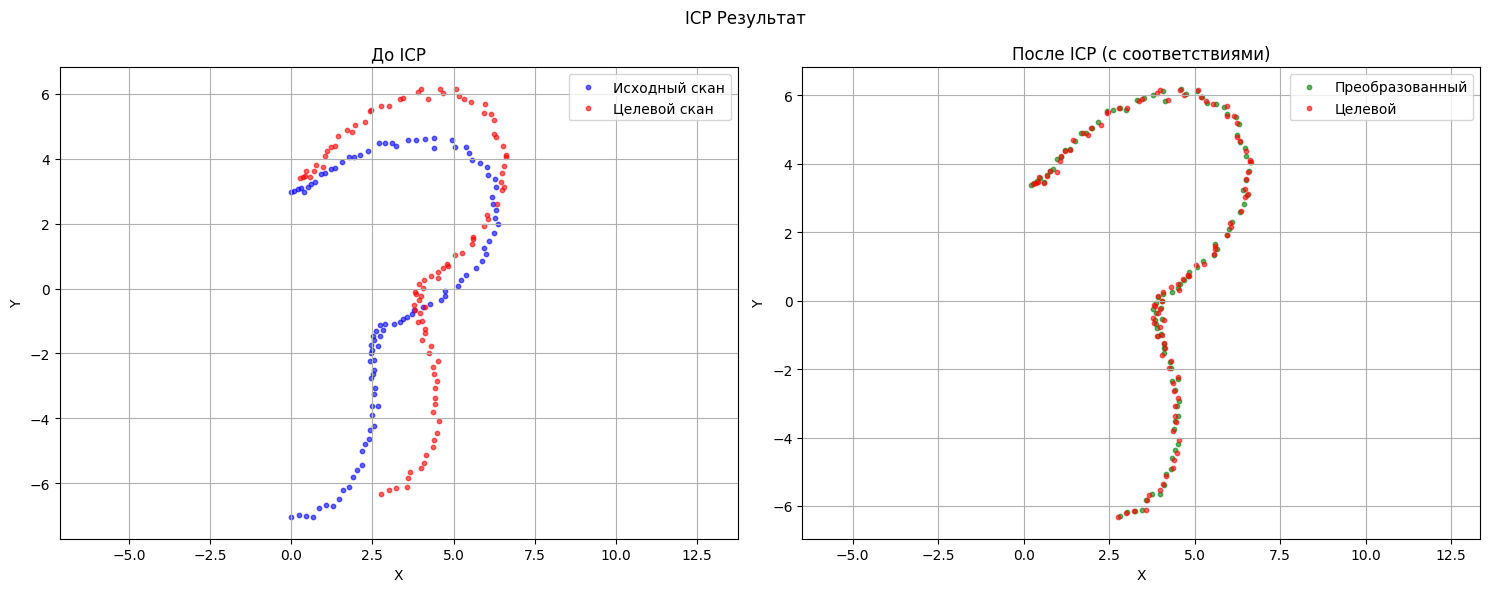

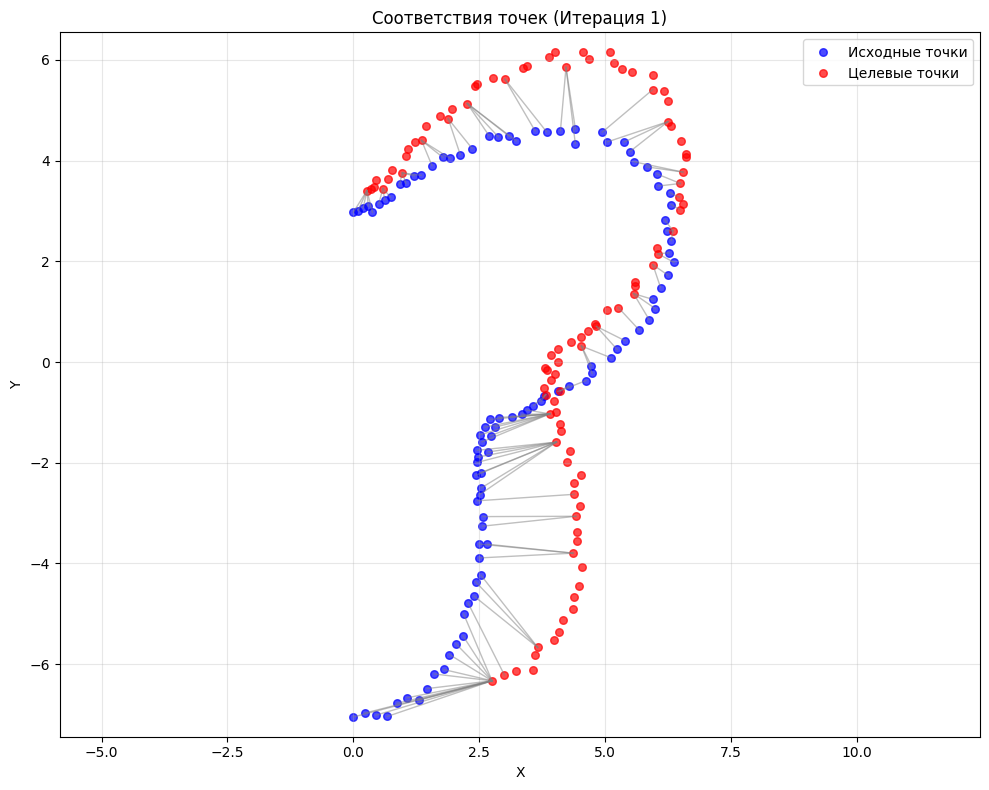

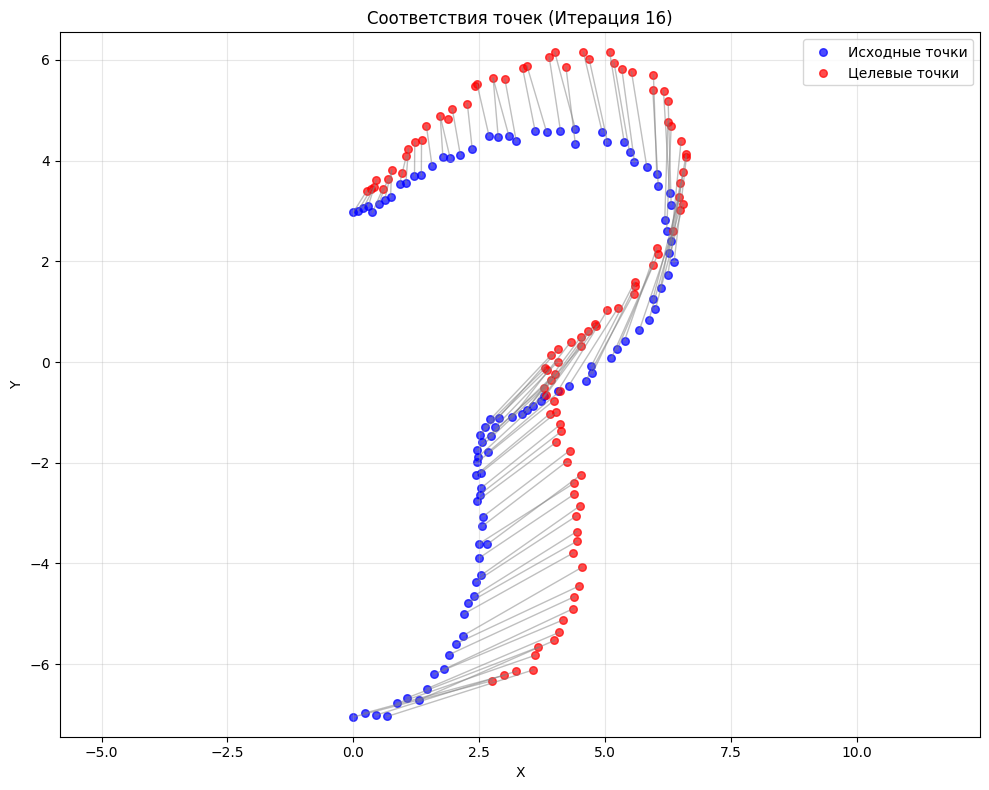

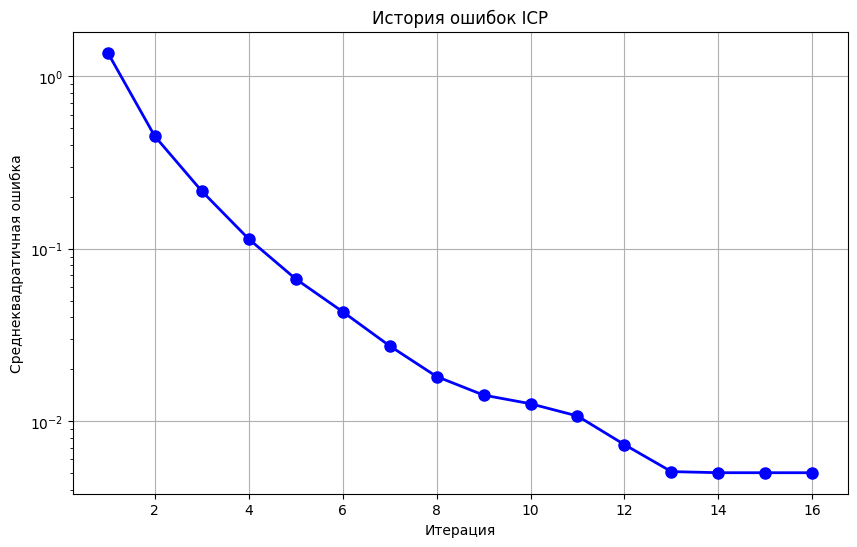


Среднее расстояние после ICP: 0.062428

Сравнение с истинным преобразованием:
Истинное смещение: (1.0000, 0.5000)
Оцененное смещение: (1.0003, 0.5071)
Истинное вращение: 15.0000 градусов
Оцененное вращение: 14.9802 градусов


In [27]:
import numpy as np
from scipy.spatial import KDTree
from scipy.optimize import minimize
import matplotlib.pyplot as plt


def polar_to_cartesian(ranges, angles):
    """Преобразование полярных координат в декартовы"""
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)
    return np.column_stack((x, y))


def cartesian_to_polar(points):
    """Преобразование декартовых координат в полярные"""
    x = points[:, 0]
    y = points[:, 1]
    ranges = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x)
    return ranges, angles


def apply_transform(points, transform_params):
    """Применение преобразования (вращение + смещение) к точкам"""
    tx, ty, theta = transform_params

    # Создаем матрицу вращения
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Применяем вращение
    rotated = np.dot(points, rotation_matrix.T)

    # Применяем смещение
    transformed = rotated + np.array([tx, ty])

    return transformed


def find_correspondences(source_points, target_kdtree):
    """Находит ближайшие соответствия между точками"""
    distances, indices = target_kdtree.query(source_points)
    return indices, distances


def icp_iteration(source_points, target_points, target_kdtree, transform_params):
    """Одна итерация ICP"""
    # Преобразуем исходные точки
    transformed_points = apply_transform(source_points, transform_params)

    # Находим соответствия
    indices, distances = find_correspondences(transformed_points, target_kdtree)

    # Получаем соответствующие целевые точки
    corresponding_target_points = target_points[indices]

    return transformed_points, corresponding_target_points, distances, indices


def icp_objective(transform_params, source_points, target_points, target_kdtree):
    """Целевая функция для оптимизации"""
    # Преобразуем исходные точки
    transformed_points = apply_transform(source_points, transform_params)

    # Находим ближайшие точки в целевом наборе
    distances, _ = target_kdtree.query(transformed_points)

    # Возвращаем сумму квадратов расстояний
    return np.sum(distances**2)


def icp_algorithm(source_ranges, source_angles, target_ranges, target_angles,
                  max_iterations=50, tolerance=1e-6):
    """
    Алгоритм ICP для сопоставления двух сканов лидара

    Parameters:
    -----------
    source_ranges : array-like
        Дистанции для исходного скана
    source_angles : array-like
        Углы для исходного скана
    target_ranges : array-like
        Дистанции для целевого скана
    target_angles : array-like
        Углы для целевого скана
    max_iterations : int
        Максимальное количество итераций
    tolerance : float
        Критерий остановки по изменению ошибки

    Returns:
    --------
    transform_params : tuple
        (tx, ty, theta) - параметры преобразования
    aligned_points : ndarray
        Точки после преобразования
    errors : list
        История ошибок на каждой итерации
    correspondences : list
        История соответствий на каждой итерации
    """

    # Преобразуем в декартовы координаты
    source_points = polar_to_cartesian(source_ranges, source_angles)
    target_points = polar_to_cartesian(target_ranges, target_angles)

    # Создаем KDTree для целевых точек
    target_kdtree = KDTree(target_points)

    # Инициализируем параметры преобразования
    transform_params = np.array([0.0, 0.0, 0.0])  # (tx, ty, theta)

    errors = []
    correspondences = []
    prev_error = float('inf')

    # Основной цикл ICP
    for iteration in range(max_iterations):
        # Шаг 1: Находим соответствия
        transformed_points, corresponding_target_points, distances, indices = icp_iteration(
            source_points, target_points, target_kdtree, transform_params
        )

        # Сохраняем соответствия для визуализации
        correspondences.append(indices)

        # Шаг 2: Оптимизируем параметры преобразования
        # Вместо минимизации расстояний до всех точек, минимизируем расстояния до соответствующих точек
        def objective_for_correspondences(params):
            transformed = apply_transform(source_points, params)
            # Вычисляем расстояния до соответствующих точек
            errors = transformed - corresponding_target_points
            return np.sum(errors**2)

        result = minimize(
            objective_for_correspondences,
            transform_params,
            method='L-BFGS-B',
            options={'maxiter': 100, 'ftol': 1e-8}
        )

        transform_params = result.x

        # Вычисляем текущую ошибку
        current_error = np.mean(distances**2)
        errors.append(current_error)

        # Проверяем критерий остановки
        error_change = abs(prev_error - current_error)
        if error_change < tolerance:
            print(f"Сходимость достигнута на итерации {iteration + 1}")
            break

        prev_error = current_error

        if (iteration + 1) % 5 == 0:
            print(f"Итерация {iteration + 1}, ошибка: {current_error:.6f}")

    # Применяем финальное преобразование
    aligned_points = apply_transform(source_points, transform_params)

    print(f"\nФинальные параметры преобразования:")
    print(f"Смещение по X: {transform_params[0]:.4f}")
    print(f"Смещение по Y: {transform_params[1]:.4f}")
    print(f"Вращение: {np.degrees(transform_params[2]):.4f} градусов")
    print(f"Финальная ошибка: {errors[-1]:.6f}")

    return transform_params, aligned_points, errors, correspondences


def filter_valid_points(ranges, angles, max_range=50.0, min_range=0.1):
    """Фильтрация валидных точек лидара"""
    mask = (ranges <= max_range) & (ranges >= min_range)
    return ranges[mask], angles[mask]


def visualize_results(source_points, target_points, aligned_points,
                      correspondences=None, iteration=None, title="ICP Результат"):
    """Визуализация результатов ICP"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # До ICP
    axes[0].scatter(source_points[:, 0], source_points[:, 1],
                    c='blue', alpha=0.6, label='Исходный скан', s=10)
    axes[0].scatter(target_points[:, 0], target_points[:, 1],
                    c='red', alpha=0.6, label='Целевой скан', s=10)
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].set_title('До ICP')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].axis('equal')

    # После ICP
    axes[1].scatter(aligned_points[:, 0], aligned_points[:, 1],
                    c='green', alpha=0.6, label='Преобразованный', s=10)
    axes[1].scatter(target_points[:, 0], target_points[:, 1],
                    c='red', alpha=0.6, label='Целевой', s=10)

    # Если есть соответствия, рисуем линии соединения
    if correspondences is not None and iteration is not None:
        # Используем соответствия для последней итерации
        if iteration < len(correspondences):
            indices = correspondences[iteration]
            for i, idx in enumerate(indices):
                if i < len(aligned_points) and idx < len(target_points):
                    axes[1].plot([aligned_points[i, 0], target_points[idx, 0]],
                               [aligned_points[i, 1], target_points[idx, 1]],
                               'gray', alpha=0.3, linewidth=0.5)

    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].set_title('После ICP (с соответствиями)' if correspondences else 'После ICP')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].axis('equal')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def visualize_correspondences(source_points, target_points, correspondences, iteration):
    """Визуализация соответствий на конкретной итерации"""
    if iteration >= len(correspondences):
        print(f"Нет данных для итерации {iteration}")
        return

    indices = correspondences[iteration]

    plt.figure(figsize=(10, 8))

    # Рисуем точки
    plt.scatter(source_points[:, 0], source_points[:, 1],
                c='blue', alpha=0.7, label='Исходные точки', s=30)
    plt.scatter(target_points[:, 0], target_points[:, 1],
                c='red', alpha=0.7, label='Целевые точки', s=30)

    # Рисуем линии соответствий
    for i, idx in enumerate(indices):
        if i < len(source_points) and idx < len(target_points):
            plt.plot([source_points[i, 0], target_points[idx, 0]],
                     [source_points[i, 1], target_points[idx, 1]],
                     'gray', alpha=0.5, linewidth=1)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Соответствия точек (Итерация {iteration + 1})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


def plot_error_history(errors):
    """Построение графика изменения ошибки"""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(errors) + 1), errors, 'b-o', linewidth=2, markersize=8)
    plt.xlabel('Итерация')
    plt.ylabel('Среднеквадратичная ошибка')
    plt.title('История ошибок ICP')
    plt.grid(True)
    plt.yscale('log')
    plt.show()


# Пример использования
if __name__ == "__main__":
    # Создаем тестовые данные - два скана лидара
    np.random.seed(42)

    # Параметры для первого скана
    n_points = 100
    angles = np.linspace(-np.pi/2, np.pi/2, n_points)
    ranges1 = 5 + 2 * np.sin(3 * angles) + np.random.normal(0, 0.1, n_points)

    # Фильтруем валидные точки
    ranges1, angles1 = filter_valid_points(ranges1, angles)

    # Создаем второй скан с преобразованием
    points1 = polar_to_cartesian(ranges1, angles1)

    # Задаем преобразование
    true_tx, true_ty, true_theta = 1.0, 0.5, np.radians(15)
    rotation_matrix = np.array([
        [np.cos(true_theta), -np.sin(true_theta)],
        [np.sin(true_theta), np.cos(true_theta)]
    ])
    points2 = np.dot(points1, rotation_matrix.T) + np.array([true_tx, true_ty])

    # Добавляем шум
    points2 += np.random.normal(0, 0.05, points2.shape)

    # Преобразуем обратно в полярные координаты
    ranges2, angles2 = cartesian_to_polar(points2)

    # Фильтруем валидные точки
    ranges2, angles2 = filter_valid_points(ranges2, angles2)

    print("Информация о данных:")
    print(f"Количество точек в исходном скане: {len(ranges1)}")
    print(f"Количество точек в целевом скане: {len(ranges2)}")
    print(f"\nИстинное преобразование:")
    print(f"Смещение: ({true_tx:.2f}, {true_ty:.2f})")
    print(f"Вращение: {np.degrees(true_theta):.2f} градусов")

    # Запускаем ICP
    transform_params, aligned_points, errors, correspondences = icp_algorithm(
        ranges1, angles1,
        ranges2, angles2,
        max_iterations=30,
        tolerance=1e-8
    )

    # Визуализация
    source_points = polar_to_cartesian(ranges1, angles1)
    target_points = polar_to_cartesian(ranges2, angles2)

    # Визуализация с соответствиями
    visualize_results(source_points, target_points, aligned_points,
                     correspondences, iteration=len(correspondences)-1)

    # Визуализация соответствий на первой и последней итерации
    visualize_correspondences(source_points, target_points, correspondences, 0)
    visualize_correspondences(source_points, target_points, correspondences, len(correspondences)-1)

    plot_error_history(errors)

    # Оцениваем точность
    # Находим соответствия для финального преобразования
    final_transformed = apply_transform(source_points, transform_params)
    target_kdtree = KDTree(target_points)
    indices, distances = find_correspondences(final_transformed, target_kdtree)

    final_error = np.mean(distances)
    print(f"\nСреднее расстояние после ICP: {final_error:.6f}")

    # Сравнение с истинным преобразованием
    print(f"\nСравнение с истинным преобразованием:")
    print(f"Истинное смещение: ({true_tx:.4f}, {true_ty:.4f})")
    print(f"Оцененное смещение: ({transform_params[0]:.4f}, {transform_params[1]:.4f})")
    print(f"Истинное вращение: {np.degrees(true_theta):.4f} градусов")
    print(f"Оцененное вращение: {np.degrees(transform_params[2]):.4f} градусов")